In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import scipy.optimize as sc

# Portfolio Optimization & Risk Analysis

## Overview

This notebook provides a comprehensive framework for **portfolio optimization using Modern Portfolio Theory (MPT)** and **risk analysis through Value at Risk (VaR) modeling**. The project demonstrates how to construct optimal portfolios, visualize the efficient frontier, and evaluate portfolio risk using multiple methodologies.

### Core Components

#### 1. **Portfolio Optimization & Construction**
   - **Efficient Frontier Analysis**: Visualizes the optimal risk-return trade-off for all possible portfolios
   - **Maximum Sharpe Ratio Portfolio**: Optimizes portfolio weights to maximize risk-adjusted returns
   - **Minimum Volatility Portfolio**: Finds the portfolio with the lowest risk for given constraints

#### 2. **Risk Measurement & VaR Modeling**
   - **Historical VaR** (Non-parametric): Uses historical return distribution quantiles
   - **Parametric VaR** (Normal distribution): Assumes normal distribution of returns
   - **Monte Carlo VaR (Uncorrelated)**: Simulates portfolio returns for single-asset scenarios
   - **Monte Carlo VaR (Correlated)**: Accounts for multi-asset correlation using Cholesky decomposition

#### 3. **Model Validation & Backtesting**
   - **Rolling Window Backtesting**: Out-of-sample validation using historical data
   - **Kupiec Likelihood Ratio Test**: Statistical test for VaR model accuracy
   - **Performance Metrics**: MAE, RMSE, and average excess loss calculations

### Dataset

This analysis uses Australian equity data from Yahoo Finance:
- **CBA**: Commonwealth Bank of Australia
- **BHP**: BHP Group Limited (BHP Group)
- **TLS**: Telstra Corporation Limited

## Table of Contents

1. **Data Preparation** - Data fetching, cleaning, missing value handling, and return calculations
2. **Portfolio Construction** - Optimal portfolio weights, efficient frontier, and risk-return optimization
3. **Risk Analysis** - VaR calculations using multiple methods and comprehensive backtesting


## 1. Data Preparation

In [11]:
def individual_performance (stockData, if_log = False):
    if if_log:
        stockData = np.log(stockData / stockData.shift(1))
        meanReturns = stockData.mean()
        covMatrix = stockData.cov()
    else:
        stockData = stockData.pct_change()
        meanReturns = stockData.mean()
        covMatrix = stockData.cov()
    
    return meanReturns, covMatrix


In [12]:
stocklist = ['CBA','BHP','TLS']

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365)

stockData = yf.download (stocklist, startDate, endDate, auto_adjust=True)
stockData = stockData['Close']
stockData

[*********************100%***********************]  3 of 3 completed


Ticker,BHP,CBA,TLS
Date,,,
2024-11-07,56.610722,0.055,4.570
2024-11-08,54.101223,0.055,4.660
2024-11-11,52.473972,0.055,4.245
2024-11-12,51.562317,0.055,3.920
2024-11-13,51.287842,0.055,3.710
...,...,...,...
2025-10-30,57.240002,0.025,6.870
2025-10-31,57.049999,0.025,6.860
2025-11-03,56.150002,0.025,6.830


In [13]:
# Check for missing values in stock data
print("=== Missing Values Check ===")
print(f"\nTotal missing values: {stockData.isnull().sum().sum()}")
print(f"Total data points: {stockData.size}")
print(f"Percentage of missing values: {(stockData.isnull().sum().sum() / stockData.size * 100):.2f}%")

print("\n--- Missing values per stock ---")
for col in stockData.columns:
    missing_count = stockData[col].isnull().sum()
    missing_pct = (missing_count / len(stockData)) * 100
    print(f"{col}: {missing_count} missing ({missing_pct:.2f}%)")

print("\n--- Sample of rows with missing values ---")
missing_rows = stockData[stockData.isnull().any(axis=1)]
if len(missing_rows) > 0:
    print(missing_rows.head(10))
    print(f"\nTotal rows with missing values: {len(missing_rows)}")
else:
    print("No missing values found!")

print("\n--- Data shape and date range ---")
print(f"Shape: {stockData.shape}")
print(f"Date range: {stockData.index[0]} to {stockData.index[-1]}")
print(f"Total days: {len(stockData)}")


=== Missing Values Check ===

Total missing values: 6
Total data points: 747
Percentage of missing values: 0.80%

--- Missing values per stock ---
BHP: 0 missing (0.00%)
CBA: 6 missing (2.41%)
TLS: 0 missing (0.00%)

--- Sample of rows with missing values ---
Ticker            BHP  CBA   TLS
Date                            
2024-12-26  48.376434  NaN  3.47
2025-05-19  50.349998  NaN  2.66
2025-07-01  48.669998  NaN  3.12
2025-08-04  51.630001  NaN  2.54
2025-10-13  55.709999  NaN  6.83
2025-11-06  55.610001  NaN  6.56

Total rows with missing values: 6

--- Data shape and date range ---
Shape: (249, 3)
Date range: 2024-11-07 00:00:00 to 2025-11-06 00:00:00
Total days: 249


In [14]:
stockData = stockData.ffill()
stockData = stockData.bfill()
stockData

Ticker,BHP,CBA,TLS
Date,,,
2024-11-07,56.610722,0.055,4.570
2024-11-08,54.101223,0.055,4.660
2024-11-11,52.473972,0.055,4.245
2024-11-12,51.562317,0.055,3.920
2024-11-13,51.287842,0.055,3.710
...,...,...,...
2025-10-30,57.240002,0.025,6.870
2025-10-31,57.049999,0.025,6.860
2025-11-03,56.150002,0.025,6.830


In [15]:
indi_return, cov_matrix = individual_performance(stockData, if_log=True) #default is simple return
print(indi_return)
print(cov_matrix)

Ticker
BHP   -0.000072
CBA   -0.003179
TLS    0.001458
dtype: float64
Ticker       BHP       CBA       TLS
Ticker                              
BHP     0.000325 -0.000384  0.000249
CBA    -0.000384  0.019642 -0.000283
TLS     0.000249 -0.000283  0.003059


## 2. Portfolio Construction

In [16]:
## Annualized portfolio metrics
def port_performance (weights, indi_Return, covariance, trading_days = 252, riskfree_rate = 0.0402): 
    # riskfree_rate: Annual risk-free rate (industry convention: 10-year government bond yield)
    # Current as of 2025: ~4.02% (0.0402)
    returns = np.sum(indi_Return * weights)*trading_days
    std = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(trading_days)
    sharpe = (returns - riskfree_rate) / std
    return returns, std, sharpe

In [17]:
def negative_sharpe (weights, indi_Return, covariance):
    return -(port_performance(weights, indi_Return, covariance)[2])

def portfolio_volatility (weights, indi_Return, covariance):
    return port_performance(weights, indi_Return, covariance)[1]

def max_sharpe_portfolio (indi_Return, covariance, riskfree_rate = 0.0402, constraintSet = (0,1)):
    numAssets = len(indi_Return)
    initial_weights = numAssets*[1./numAssets]
    
    constraints = ({'type':'eq','fun':lambda x:np.sum(x)-1})
    bounds = tuple(constraintSet for asset in range (numAssets))
    optimized_result = sc.minimize(negative_sharpe, initial_weights, args = (indi_Return, covariance), method ='SLSQP',
                         bounds = bounds, constraints = constraints)
    return optimized_result

def min_volatility_portfolio (indi_Return, covariance):
    numAssets = len(indi_Return)
    initial_weights = numAssets*[1./numAssets]
    constraints = ({'type':'eq','fun':lambda x:np.sum(x)-1})
    bounds = tuple((0,1) for asset in range (numAssets))
    optimized_result = sc.minimize(portfolio_volatility, initial_weights, args = (indi_Return, covariance), method ='SLSQP',
                         bounds = bounds, constraints = constraints)
    return optimized_result      

### (1) Optimal Portfolio --- Min-Vol & Max-Sharpe

In [18]:
# Set numpy print options to display decimals instead of scientific notation
np.set_printoptions(suppress=True, precision=4)
# 1. Max Sharpe 
max_result = max_sharpe_portfolio(indi_return, cov_matrix)
min_result = min_volatility_portfolio(indi_return,cov_matrix)

# Output Display
max_weights = pd.Series(max_result.x, index=indi_return.index)
maxSR_return = port_performance(max_result.x, indi_return, cov_matrix)[0]
maxSR_std = port_performance(max_result.x, indi_return, cov_matrix)[1]
print('--- Optimal Portfolio Weights ---')
print('\n📈 Maximum Sharpe Portfolio:')
print(max_weights.map (lambda x:f"{x:.2%}"))
print(f"Return: {maxSR_return:.2%}, Volatility: {maxSR_std:.2%}")

min_weights = pd.Series(min_result.x, index=indi_return.index)
minVOL_return = port_performance(min_result.x, indi_return, cov_matrix)[0]
minVOL_std = port_performance(min_result.x, indi_return, cov_matrix)[1]
print('\n📈 Minimum Volatility Portfolio:')
print(min_weights.map (lambda x:f"{x:.2%}"))
print(f"Return: {minVOL_return:.2%}, Volatility: {minVOL_std:.2%}")

--- Optimal Portfolio Weights ---

📈 Maximum Sharpe Portfolio:
Ticker
BHP      0.00%
CBA      0.00%
TLS    100.00%
dtype: object
Return: 36.73%, Volatility: 87.80%

📈 Minimum Volatility Portfolio:
Ticker
BHP    94.18%
CBA     3.39%
TLS     2.42%
dtype: object
Return: -3.54%, Volatility: 27.44%


### (2) Efficient Frontier

In [19]:
def efficient_return (indi_Return, covariance, target_return, constraintSet = (0,1)):
    """Finds the portfolio with the minimum volatility for a given target return."""
    numAssets = len(indi_Return)
    args = (indi_Return, covariance)
    initial_weights = numAssets*[1./numAssets]
    
    # Constraint 2: Portfolio return must equal the target return
    constraints_ef = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: port_performance(weights, indi_Return, covariance)[0] - target_return} 
    )
    bounds = tuple(constraintSet for asset in range (numAssets))
    # Minimize volatility subject to the target return constraint
    optimized_result= sc.minimize(
        portfolio_volatility, 
        initial_weights, 
        args=args, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints_ef
    )
    return optimized_result

def efficient_frontier (indi_Return, covariance, minVOL_ret, max_ret):
    """Calculates a series of optimal portfolios to plot the frontier."""
    # Define a range of returns from the min vol portfolio return up to the max asset return
    target_returns = np.linspace(minVOL_ret, max_ret, 100)
    
    efficient_portfolios = []
    for target in target_returns:
        efficient_portfolios.append(efficient_return(indi_Return, covariance, target))
        
    # Extract Volatility and Return for the Frontier curve
    frontier_vols = [p['fun'] for p in efficient_portfolios]
    frontier_rets = target_returns
    
    return frontier_rets, frontier_vols

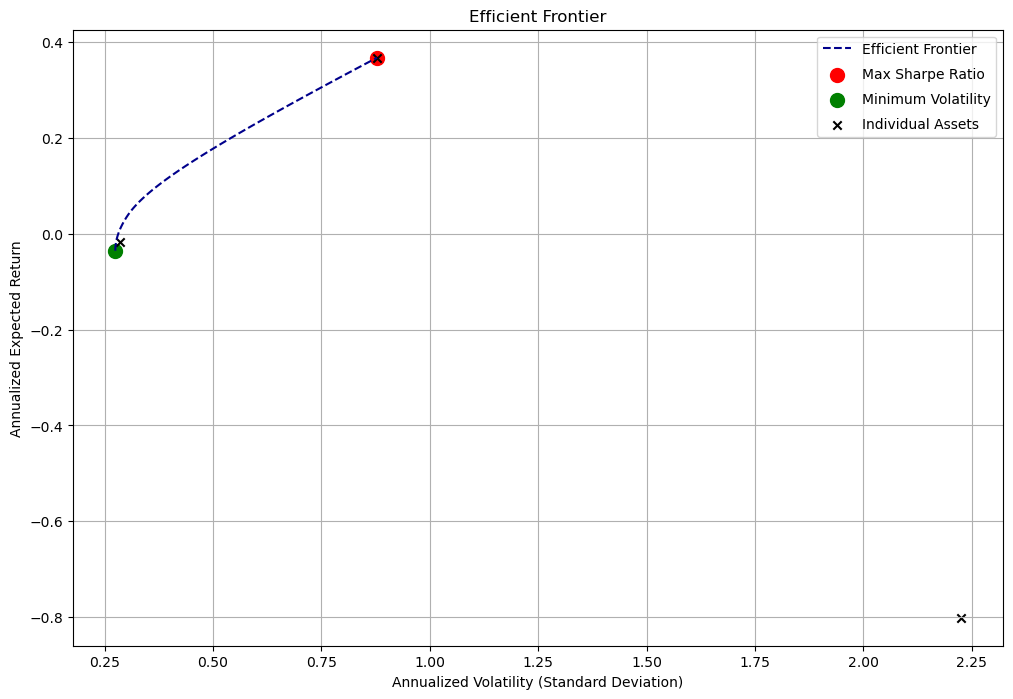

In [20]:
# Calculate maximum possible annualized return (highest individual asset return)
max_return_annual = indi_return.max() * 252

# Generate efficient frontier from min vol to maximum possible return
frontier_rets, frontier_vols = efficient_frontier(indi_return, cov_matrix, minVOL_return, max_return_annual)

# Plot Efficient Frontier 
plt.figure(figsize=(12, 8))
plt.plot(frontier_vols, frontier_rets, linestyle='--', color='darkblue', label='Efficient Frontier')

# Plot Optimal Portfolio
plt.scatter(maxSR_std, maxSR_return, marker='o', color='red', s=100, label='Max Sharpe Ratio')
plt.scatter(minVOL_std, minVOL_return, marker='o', color='green', s=100, label='Minimum Volatility')

# Plot Individual Assets
plt.scatter(np.sqrt(np.diag(cov_matrix))*np.sqrt(252), indi_return*252, marker='x', color='black', label='Individual Assets')

plt.title('Efficient Frontier')
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return')
plt.legend(labelspacing=0.8)
plt.grid(True)
plt.show()

## 3. Risk Analysis

### (1) VaR -- Historical + Parametric + Monte-Carlo

In [21]:
# Historical VaR (Non-parametric: simply the corresponding percentile)
def historical_VaR (returns, alpha):
    if isinstance(returns, pd.Series):
        var_hist = returns.quantile(alpha)
        es_hist = returns[returns <= var_hist].mean()
    elif isinstance(returns, pd.DataFrame):
        var_hist = returns.aggregate (historical_VaR)
        es_hist = returns.aggregate (returns[returns <= var_hist].mean())
    else: 
        raise TypeError("Wrong data input type!")
    es_hist = returns[returns <= var_hist].mean()
    return -var_hist, -es_hist

# Parametric VaR (assumptions on the historical return distribution to define mean and std parameters for the VaR model)
def parametric_VaR (returns, alpha, distribution = 'normal', dof= 6):
    if distribution == 'normal':   
        mu = returns.mean()
        sigma = returns.std()
    
        z_score = norm.ppf(alpha)
        var_param = mu + z_score * sigma
    elif distribution == 't-distribution':
        var_param = np.sqrt((dof-2)/dof) * t.ppf(1-alpha/100, dof) * sigma - mu
    else:
        raise TypeError("Expected distribution not satisfied")
    es_param = returns[returns <= var_param].mean()
    return -var_param, -es_param 

# Monte-carlo Simulated VaR (Single Asset or Portfolio Returns)
def montecarlo_VaR_single (returns, alpha, time_horizon, num_sim = 1000):
    means = np.full(shape = (time_horizon,), fill_value=returns.mean())
    portfolio_sims = np.full(shape=(time_horizon, num_sim), fill_value=0.0)
    
    initial_value = 1
# --- Monte Carlo Loops ---
    for i in range(num_sim):
        Z = np.random.normal(size=time_horizon)
        
        # 2. Calculate daily returns (Mean + Volatility * Shock)
        # Volatility is now a simple scalar (stdDev)
        # We use simple scaling for the daily returns: E(R) + std * Z
        dailyReturns = means + returns.std() * Z
        
        # 3. Calculate the portfolio value path using compounding
        # Since there are no weights, dailyReturns ARE the daily portfolio returns
        portfolio_sims[:,i] = np.cumprod(dailyReturns + 1) * initial_value

# Note: VaR and ES would be calculated from the final row of portfolio_sims
# Example: VaR = np.percentile(portfolio_sims[-1, :] - initialPortfolio, alpha * 100)
    simulated_returns = portfolio_sims[-1,:]-initial_value
    
    var_mc = np.percentile (simulated_returns, alpha*100)
    es_mc = np.mean(simulated_returns[simulated_returns <= var_mc])
    return -var_mc, -es_mc
    
# Monte-carlo Simulated VaR (Multi-Asset Portfolio with Correlation)
def montecarlo_VaR_correlated (indi_returns, alpha, time_horizon, cov_matrix, weights, num_sim = 1000):
    num_assets = len(weights)
    # Get mean returns for each asset
    if isinstance(indi_returns, pd.DataFrame):
        mean_daily = indi_returns.mean().values
    else:
        mean_daily = np.mean(indi_returns, axis=0)
    
    # Cholesky decomposition for correlation structure
    L = np.linalg.cholesky(cov_matrix)
    
    # Initialize array to store simulated portfolio returns
    simulated_returns = np.zeros(num_sim)
    initial_value = 1.0

    # Run Monte Carlo simulations
    for i in range(num_sim):
        # Generate uncorrelated random shocks for each day and asset
        Z = np.random.normal(size=(time_horizon, num_assets))
        
        # Apply Cholesky decomposition to introduce correlation
        # For each time step, transform the independent shocks
        portfolio_value = initial_value
        
        for t in range(time_horizon):
            # Correlated shocks for this time step
            correlated_shocks = L @ Z[t, :]
            
            # Simulated returns for each asset: mean + shock
            asset_returns = mean_daily + correlated_shocks
            
            # Portfolio return for this time step
            portfolio_return = np.dot(weights, asset_returns)
            
            # Update portfolio value
            portfolio_value *= (1 + portfolio_return)
        
        # Store the final return/loss for this simulation path
        simulated_returns[i] = portfolio_value - initial_value
    
    # Calculate VaR and ES
    var_mc = np.percentile(simulated_returns, alpha * 100)
    es_mc = simulated_returns[simulated_returns <= var_mc].mean()
    
    return -var_mc, -es_mc

In [22]:
confidence_level = 0.95
time_horizon = 1 # 1-day VaR
alpha = 1 - confidence_level

indi_assets = np.log(stockData / stockData.shift(1))
returns = indi_assets.dot(min_result.x) #portfolio return for minimum volatility portfolio

VaR_H, ES_H = historical_VaR(returns, alpha)
VaR_P, ES_P = parametric_VaR(returns, alpha)
VaR_MC1, ES_MC1 = montecarlo_VaR_single(returns, alpha, time_horizon)
VaR_MC2, ES_MC2 = montecarlo_VaR_correlated(indi_assets.dropna(), alpha, time_horizon, cov_matrix, min_result.x)

# --- Reporting ---
results = pd.DataFrame({
    'VaR (95%)': [VaR_H, VaR_P, VaR_MC1, VaR_MC2],
    'ES (95%)': [ES_H, ES_P, ES_MC1, ES_MC2]
}, index=['Historical', 'Parametric', 'Monte Carlo - Uncorrelated', 'Monte Carlo - Correlated'])

print("\n------ 1-Day VaR and ES Results (Daily %) ------")
print(results.map(lambda x: f"{x:.3%}"))


------ 1-Day VaR and ES Results (Daily %) ------
                           VaR (95%) ES (95%)
Historical                    2.508%   3.828%
Parametric                    2.857%   4.192%
Monte Carlo - Uncorrelated    2.739%   3.518%
Monte Carlo - Correlated      2.680%   3.388%


### (2) VaR Backtesting 

In [23]:
def backtest_VaR(returns, weights, cov_matrix, alpha=0.05, time_horizon=1, 
                 rolling_window=252, num_sim=1000):
      
    portfolio_returns = returns.dot(weights)

    actual_returns_list = []
    var_historical_list = []
    var_parametric_list = []
    var_mc_single_list = []
    var_mc_correlated_list = []
    dates_list = []
    
    # Rolling window backtest
    print("Running rolling window backtest...")
    for i in range(rolling_window, len(portfolio_returns) - time_horizon):
        # Get training window
        train_returns = portfolio_returns.iloc[i-rolling_window:i]
        train_asset_returns = returns.iloc[i-rolling_window:i]
        
        # Recalculate covariance matrix on training window
        train_cov = train_asset_returns.cov()
        
        # Calculate VaR for each model
        try:
            var_h, _ = historical_VaR(train_returns, alpha)
            var_p, _ = parametric_VaR(train_returns, alpha)
            var_mc1, _ = montecarlo_VaR_single(train_returns, alpha, time_horizon, num_sim)
            var_mc2, _ = montecarlo_VaR_correlated(train_asset_returns, alpha, time_horizon, 
                                                    train_cov, weights, num_sim)
            
            # Get actual return for the next period
            if time_horizon == 1:
                actual_return = portfolio_returns.iloc[i]
            else:
                # For multi-day horizon, use cumulative return
                future_returns = portfolio_returns.iloc[i:i+time_horizon]
                actual_return = (1 + future_returns).prod() - 1
            
            # Store results
            actual_returns_list.append(actual_return)
            var_historical_list.append(var_h)
            var_parametric_list.append(var_p)
            var_mc_single_list.append(var_mc1)
            var_mc_correlated_list.append(var_mc2)
            dates_list.append(portfolio_returns.index[i])
            
        except Exception as e:
            print(f"Error at index {i}: {e}")
            continue
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Date': dates_list,
        'Actual_Return': actual_returns_list,
        'VaR_Historical': var_historical_list,
        'VaR_Parametric': var_parametric_list,
        'VaR_MC_Single': var_mc_single_list,
        'VaR_MC_Correlated': var_mc_correlated_list
    })
    results_df.set_index('Date', inplace=True)
    
    return results_df


def calculate_backtest_metrics(results_df, alpha=0.05):
    """
    Calculate backtesting metrics for VaR models.
    
    Metrics include:
    1. Violation Rate: Percentage of times actual loss exceeded VaR
    2. Violation Ratio: Actual violations / Expected violations
    3. Kupiec Test (p-value): Tests if violation rate matches expected rate
    4. Average Excess Loss: Average loss when VaR is exceeded
    5. Mean Absolute Error: Average absolute difference between VaR and actual loss
    6. Root Mean Square Error: RMSE of VaR predictions
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Results from backtest_VaR function
    alpha : float
        Significance level
    
    Returns:
    --------
    metrics : pd.DataFrame
        DataFrame with backtesting metrics
    """
    from scipy.stats import chi2
    
    var_columns = ['VaR_Historical', 'VaR_Parametric', 'VaR_MC_Single', 'VaR_MC_Correlated']
    metrics_dict = {}
    
    n_obs = len(results_df)
    expected_violations = alpha * n_obs
    
    for var_col in var_columns:
        # Violations: when actual loss (negative return) exceeds VaR
        # VaR is a positive number representing potential loss
        violations = (results_df['Actual_Return'] < -results_df[var_col]).sum()
        violation_rate = violations / n_obs
        violation_ratio = violations / expected_violations if expected_violations > 0 else np.nan
        
        # Kupiec Likelihood Ratio Test
        if violations > 0 and violations < n_obs:
            p_hat = violations / n_obs
            lr_stat = -2 * (np.log((1-alpha)**(n_obs-violations) * alpha**violations) - 
                           np.log((1-p_hat)**(n_obs-violations) * p_hat**violations))
            kupiec_pvalue = 1 - chi2.cdf(lr_stat, df=1)
        else:
            kupiec_pvalue = 0.0
        
        # Average excess loss when VaR is breached
        violation_mask = results_df['Actual_Return'] < -results_df[var_col]
        if violation_mask.sum() > 0:
            excess_losses = -results_df.loc[violation_mask, 'Actual_Return'] - results_df.loc[violation_mask, var_col]
            avg_excess_loss = excess_losses.mean()
        else:
            avg_excess_loss = 0.0
        
        # Mean Absolute Error
        mae = np.abs(-results_df['Actual_Return'] - results_df[var_col]).mean()
        
        # Root Mean Square Error
        rmse = np.sqrt(((- results_df['Actual_Return'] - results_df[var_col])**2).mean())
        
        # Store metrics
        metrics_dict[var_col] = {
            'Violations': violations,
            'Violation_Rate': violation_rate,
            'Expected_Rate': alpha,
            'Violation_Ratio': violation_ratio,
            'Kupiec_p_value': kupiec_pvalue,
            'Avg_Excess_Loss': avg_excess_loss,
            'MAE': mae,
            'RMSE': rmse
        }
    
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.index = ['Historical', 'Parametric', 'MC Single', 'MC Correlated']
    
    return metrics_df


In [24]:
# Run backtest
backtest_results = backtest_VaR(
    returns=indi_assets.dropna(),
    weights=min_result.x,
    cov_matrix=cov_matrix,
    alpha=0.05,
    time_horizon=1,
    rolling_window=120,  # Using 120 days (~6 months) for faster computation
    num_sim=1000
)

print(f"\nBacktest completed with {len(backtest_results)} observations")
backtest_results.head(10)


Running rolling window backtest...

Backtest completed with 127 observations


,Actual_Return,VaR_Historical,VaR_Parametric,VaR_MC_Single,VaR_MC_Correlated
Date,,,,,
2025-05-06,0.002842,0.027809,0.032404,0.033192,0.032295
2025-05-07,-0.009205,0.025288,0.031414,0.031388,0.029685
2025-05-08,0.003281,0.023043,0.030919,0.033038,0.031321
2025-05-09,0.004324,0.023043,0.030628,0.030384,0.029538
2025-05-12,0.029686,0.023043,0.030537,0.030383,0.031286
2025-05-13,0.018996,0.023043,0.030574,0.029847,0.029123
2025-05-14,-0.018205,0.023043,0.030536,0.032372,0.030949
2025-05-15,0.004481,0.023043,0.030850,0.031427,0.029492
2025-05-16,0.000261,0.023043,0.030840,0.030401,0.029751


In [25]:
# Calculate backtesting metrics
metrics = calculate_backtest_metrics(backtest_results, alpha=0.05)

print("\n" + "="*80)
print("VaR BACKTESTING METRICS (95% Confidence Level)")
print("="*80)
print("\n--- Violation Statistics ---")
print(metrics[['Violations', 'Violation_Rate', 'Expected_Rate', 'Violation_Ratio']].to_string())

print("\n--- Statistical Tests ---")
print("Kupiec Test p-value (>0.05 indicates model is accurate):")
print(metrics['Kupiec_p_value'].to_string())

print("\n--- Accuracy Metrics ---")
print(metrics[['Avg_Excess_Loss', 'MAE', 'RMSE']].to_string())

print("\n" + "="*80)
print("INTERPRETATION GUIDE:")
print("="*80)
print("1. Violation Rate: Should be close to 5% (alpha=0.05)")
print("2. Violation Ratio: Should be close to 1.0 (actual = expected)")
print("3. Kupiec p-value: >0.05 indicates model passes (not rejected)")
print("4. Avg Excess Loss: Lower is better (avg loss when VaR is breached)")
print("5. MAE/RMSE: Lower is better (prediction accuracy)")
print("="*80)



VaR BACKTESTING METRICS (95% Confidence Level)

--- Violation Statistics ---
               Violations  Violation_Rate  Expected_Rate  Violation_Ratio
Historical            7.0        0.055118           0.05         1.102362
Parametric            3.0        0.023622           0.05         0.472441
MC Single             4.0        0.031496           0.05         0.629921
MC Correlated         3.0        0.023622           0.05         0.472441

--- Statistical Tests ---
Kupiec Test p-value (>0.05 indicates model is accurate):
Historical       0.794445
Parametric       0.129949
MC Single        0.305923
MC Correlated    0.129949

--- Accuracy Metrics ---
               Avg_Excess_Loss       MAE      RMSE
Historical            0.007962  0.025583  0.029347
Parametric            0.011043  0.031290  0.034748
MC Single             0.008350  0.031288  0.034785
MC Correlated         0.010429  0.031218  0.034745

INTERPRETATION GUIDE:
1. Violation Rate: Should be close to 5% (alpha=0.05)
2. Vio

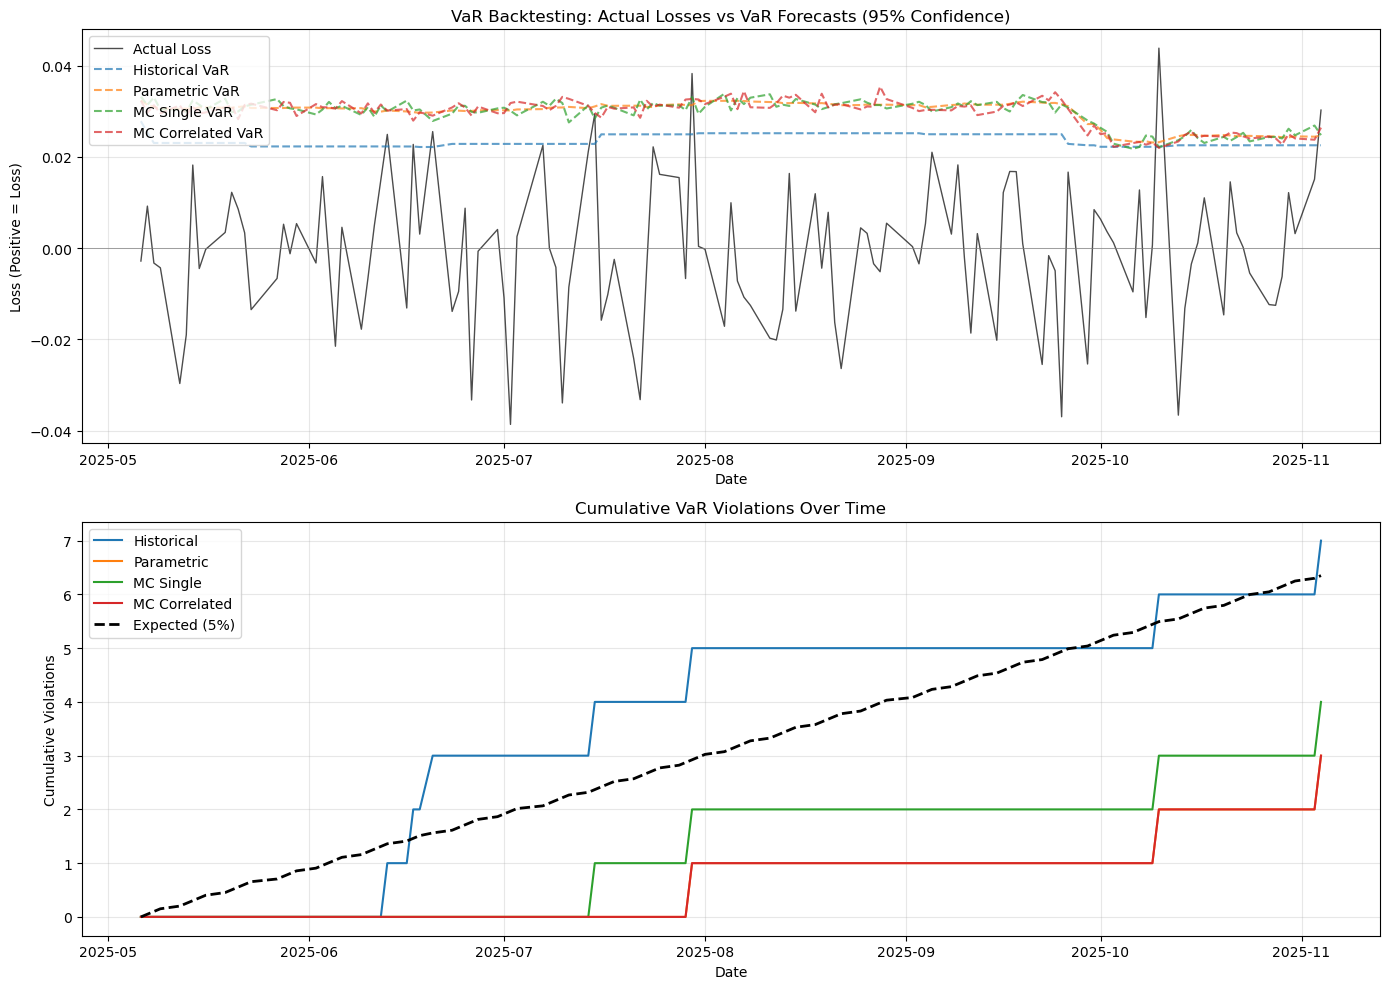

In [26]:
# Visualize backtest results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Returns vs VaR Forecasts
ax1 = axes[0]
ax1.plot(backtest_results.index, -backtest_results['Actual_Return'], 
         label='Actual Loss', color='black', linewidth=1, alpha=0.7)
ax1.plot(backtest_results.index, backtest_results['VaR_Historical'], 
         label='Historical VaR', linestyle='--', alpha=0.7)
ax1.plot(backtest_results.index, backtest_results['VaR_Parametric'], 
         label='Parametric VaR', linestyle='--', alpha=0.7)
ax1.plot(backtest_results.index, backtest_results['VaR_MC_Single'], 
         label='MC Single VaR', linestyle='--', alpha=0.7)
ax1.plot(backtest_results.index, backtest_results['VaR_MC_Correlated'], 
         label='MC Correlated VaR', linestyle='--', alpha=0.7)

ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Loss (Positive = Loss)')
ax1.set_title('VaR Backtesting: Actual Losses vs VaR Forecasts (95% Confidence)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Violations over time
ax2 = axes[1]
for var_col, label, color in [('VaR_Historical', 'Historical', 'C0'),
                                ('VaR_Parametric', 'Parametric', 'C1'),
                                ('VaR_MC_Single', 'MC Single', 'C2'),
                                ('VaR_MC_Correlated', 'MC Correlated', 'C3')]:
    violations = (backtest_results['Actual_Return'] < -backtest_results[var_col]).astype(int)
    cumulative_violations = violations.cumsum()
    ax2.plot(backtest_results.index, cumulative_violations, label=label, color=color)

# Expected violations line
n_obs = len(backtest_results)
expected_line = np.linspace(0, n_obs * 0.05, n_obs)
ax2.plot(backtest_results.index, expected_line, 'k--', label='Expected (5%)', linewidth=2)

ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Violations')
ax2.set_title('Cumulative VaR Violations Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


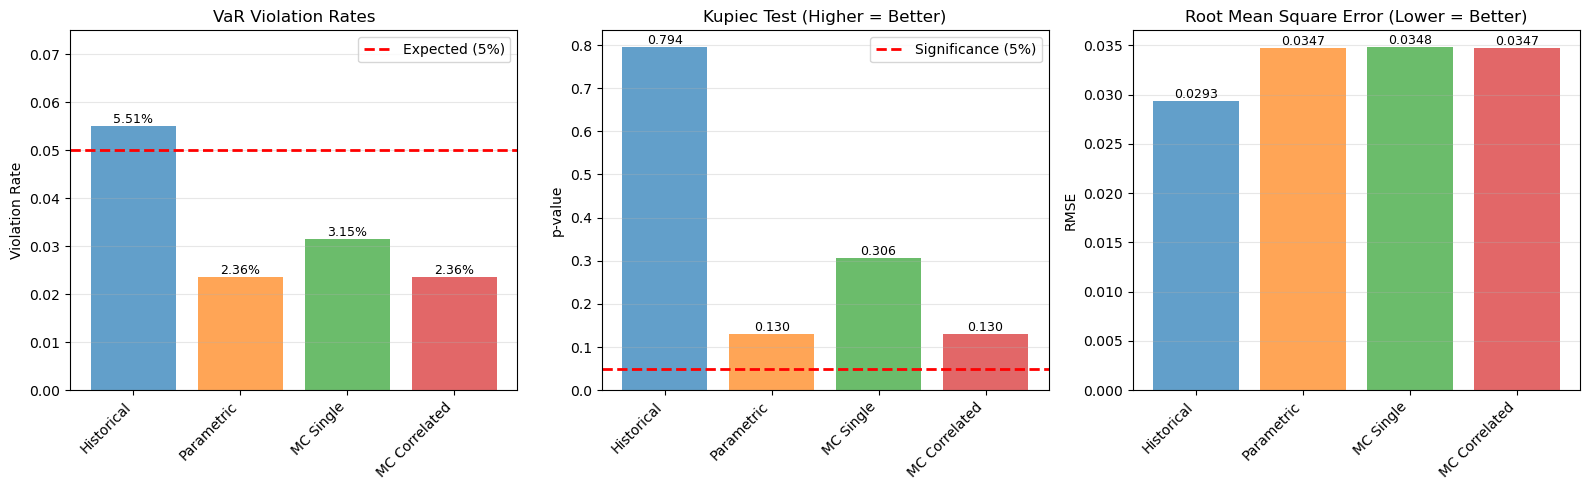


MODEL RANKING SUMMARY

📊 Ranking by Violation Accuracy (closest to 5%):
1. Historical: 5.51% (diff: 0.51%)
2. MC Single: 3.15% (diff: 1.85%)
3. Parametric: 2.36% (diff: 2.64%)
4. MC Correlated: 2.36% (diff: 2.64%)

📊 Ranking by Kupiec Test (highest p-value):
1. Historical: p-value = 0.7944 ✓ Pass
2. MC Single: p-value = 0.3059 ✓ Pass
3. Parametric: p-value = 0.1299 ✓ Pass
4. MC Correlated: p-value = 0.1299 ✓ Pass

📊 Ranking by RMSE (lowest is best):
1. Historical: RMSE = 0.0293
2. MC Correlated: RMSE = 0.0347
3. Parametric: RMSE = 0.0347
4. MC Single: RMSE = 0.0348

🏆 OVERALL RECOMMENDATION:

Best performing model: Historical
Overall score: 4.00/4.00

All model scores:
  Historical: 4.00/4.00
  Parametric: 2.30/4.00
  MC Single: 2.10/4.00
  MC Correlated: 1.60/4.00


In [27]:
# Create a comparison visualization of key metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = ['Historical', 'Parametric', 'MC Single', 'MC Correlated']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot 1: Violation Rates
ax1 = axes[0]
violation_rates = metrics['Violation_Rate'].values
expected_rate = 0.05
bars1 = ax1.bar(models, violation_rates, color=colors, alpha=0.7)
ax1.axhline(y=expected_rate, color='red', linestyle='--', linewidth=2, label='Expected (5%)')
ax1.set_ylabel('Violation Rate')
ax1.set_title('VaR Violation Rates')
ax1.set_ylim([0, max(violation_rates.max() * 1.2, expected_rate * 1.5)])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=9)

# Plot 2: Kupiec Test p-values
ax2 = axes[1]
kupiec_pvalues = metrics['Kupiec_p_value'].values
bars2 = ax2.bar(models, kupiec_pvalues, color=colors, alpha=0.7)
ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Significance (5%)')
ax2.set_ylabel('p-value')
ax2.set_title('Kupiec Test (Higher = Better)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=9)

# Plot 3: RMSE Comparison
ax3 = axes[2]
rmse_values = metrics['RMSE'].values
bars3 = ax3.bar(models, rmse_values, color=colors, alpha=0.7)
ax3.set_ylabel('RMSE')
ax3.set_title('Root Mean Square Error (Lower = Better)')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Determine best model
print("\n" + "="*80)
print("MODEL RANKING SUMMARY")
print("="*80)

# Rank by different criteria
print("\n📊 Ranking by Violation Accuracy (closest to 5%):")
violation_diff = np.abs(metrics['Violation_Rate'] - 0.05)
violation_ranking = violation_diff.sort_values()
for i, (model, diff) in enumerate(violation_ranking.items(), 1):
    print(f"{i}. {model}: {metrics.loc[model, 'Violation_Rate']:.2%} (diff: {diff:.2%})")

print("\n📊 Ranking by Kupiec Test (highest p-value):")
kupiec_ranking = metrics['Kupiec_p_value'].sort_values(ascending=False)
for i, (model, pval) in enumerate(kupiec_ranking.items(), 1):
    pass_fail = "✓ Pass" if pval > 0.05 else "✗ Fail"
    print(f"{i}. {model}: p-value = {pval:.4f} {pass_fail}")

print("\n📊 Ranking by RMSE (lowest is best):")
rmse_ranking = metrics['RMSE'].sort_values()
for i, (model, rmse) in enumerate(rmse_ranking.items(), 1):
    print(f"{i}. {model}: RMSE = {rmse:.4f}")

print("\n" + "="*80)
print("🏆 OVERALL RECOMMENDATION:")
print("="*80)
# Simple scoring system
scores = {}
for model in models:
    score = 0
    # Violation accuracy (30% weight)
    score += (4 - list(violation_diff.index).index(model)) * 0.3
    # Kupiec test (40% weight) 
    score += (4 - list(kupiec_ranking.index).index(model)) * 0.4
    # RMSE (30% weight)
    score += (4 - list(rmse_ranking.index).index(model)) * 0.3
    scores[model] = score

best_model = max(scores, key=scores.get)
print(f"\nBest performing model: {best_model}")
print(f"Overall score: {scores[best_model]:.2f}/4.00")
print("\nAll model scores:")
for model, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model}: {score:.2f}/4.00")
print("="*80)
